In [251]:
from Dataset import Dataset
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold
import sklearn.feature_selection
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    plot,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)

from dtuimldmtools import bmplot, feature_selector_lr, rlr_validate



In [252]:
dataset = Dataset(original_data=False)
for i, n in enumerate(dataset.attributeNames):
    print(i, n)
attribute_to_predict = 3 # weight
y = dataset.X_mean_std[:, attribute_to_predict]  # we want to predcit the weight
X = np.delete(dataset.X_mean_std, attribute_to_predict, 1)  # delete fourth column out of matrix
# X = dataset.X_mean_std[:, 2] # height i think
attributeNames = np.delete(dataset.attributeNames, attribute_to_predict)
N, M = X.shape

0 Gender
1 Age
2 Height
3 Weight
4 family_history_with_overweight
5 NCP
6 CH2O
7 FAF
8 TUE
9 CALC
10 MTRANS
11 NObeyesdad


In [253]:
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = np.concatenate([np.array(["Offset"]), attributeNames])
M = len(attributeNames)

In [254]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = KFold(K, shuffle=True)

# Values of lambda
lambdas = np.power(10.0, np.arange(-1, 10, 1))

# Initialize variables
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))

w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08
 1.e+09]
[0.04364247 0.04364196 0.04368124 0.04756907 0.16076647 0.65655129
 0.94286873 0.98480172 0.98918714 0.98962768 0.98967176]
[0.04404168 0.04404123 0.04408163 0.04799733 0.16043222 0.6601614
 0.95114515 0.99381519 0.99827836 0.99872673 0.99877158]
[0.04456286 0.04456298 0.04460963 0.04863793 0.16332678 0.66969888
 0.96570877 1.00925525 1.01381224 1.01427005 1.01431585]
[0.04409775 0.04409738 0.0441397  0.04813821 0.16089757 0.65774531
 0.95012789 0.99323715 0.99774965 0.998203   0.99824836]
[0.04373917 0.04373798 0.04377175 0.04768687 0.16155861 0.66238743
 0.95405671 0.99690907 1.00139262 1.00184304 1.00188811]
[0.04300265 0.04300233 0.04304496 0.0470504  0.16163374 0.66025227
 0.94802021 0.99019553 0.99460691 0.99505007 0.99509441]
[0.04467055 0.04467015 0.04471182 0.04868536 0.16185868 0.6622874
 0.95458632 0.99754317 1.00203779 1.00248933 1.0025345 ]
[0.04462316 0.04462318 0.04466964 0.04873577 0.1626997

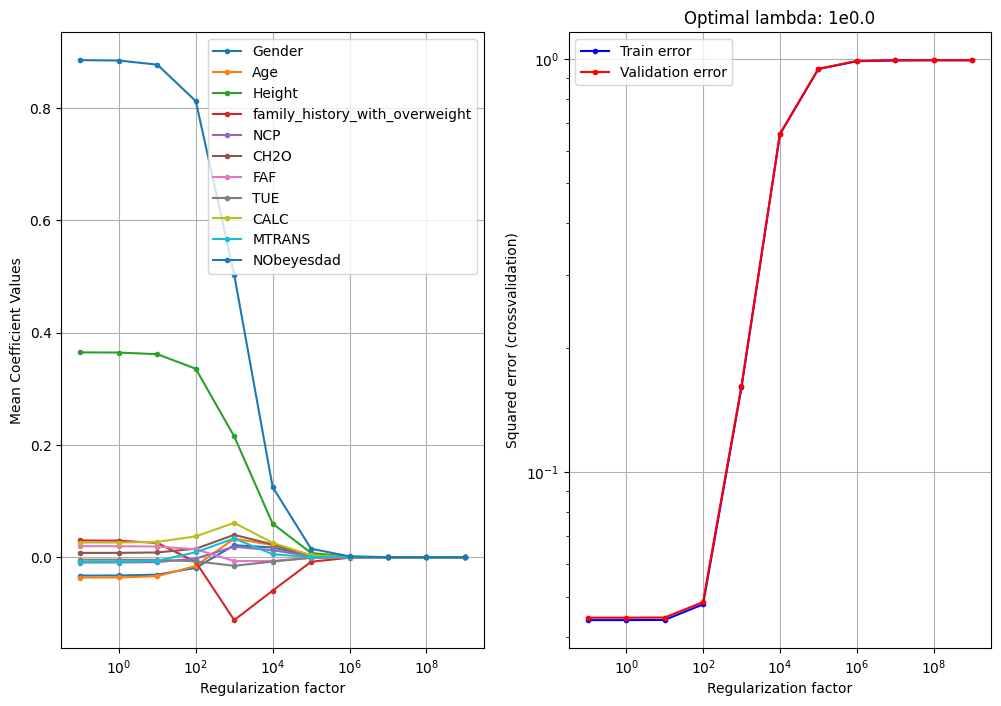

In [255]:
k = 0
print(lambdas)
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    print(test_err_vs_lambda)
    

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts

    # mu[k, :] = np.mean(X_train[:, 1:], 0)
    # sigma[k, :] = np.std(X_train[:, 1:], 0)

    # X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    # X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )


    # Estimate weights for the optimal value of lambda, on entire training set

    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )


    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    m = LinearRegression().fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

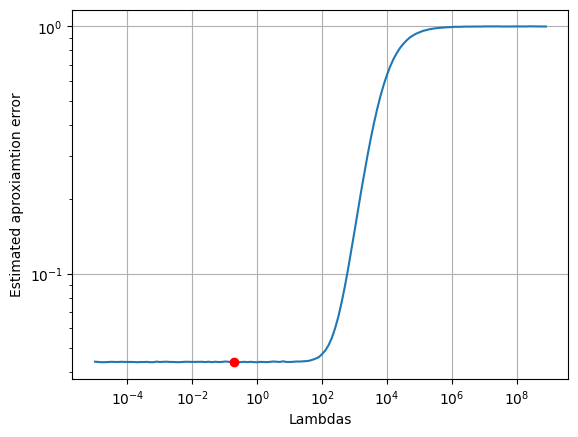

In [ ]:
# generalization error as a function of lambda
lambdas = np.power(10,np.arange(-5, 9, 0.1).astype(float))
T = len(lambdas)
K = 10

Error_per_lambda_train = np.empty((K, T)) # rows are errors of the test/train splits | cols are lambdas
Error_per_lambda_test = np.empty((K, T))
w_regularization = np.empty((M, T)) # rows are omegas for the atributs | cols are lambdas

for i, l in  enumerate(lambdas):
    k = 0
    for train_index, test_index in CV.split(X, y):
        # extract training and test set for current CV fold
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        internal_cross_validation = 10

    
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train


        lambdaI = l * np.eye(M)
        lambdaI[0, 0] = 0  # Do no regularize the bias term
        w_regularization[:, i] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
        # Compute mean squared error with regularization with optimal lambda
        Error_per_lambda_train[k, i] = (
            np.square(y_train - X_train @ w_regularization[:, i]).sum(axis=0) / y_train.shape[0]
            # np.mean(y_train - X_train @ w_regularization[:, i], axis=0)
        )
        Error_per_lambda_test[k, i] = (
            np.square(y_test - X_test @ w_regularization[:, i]).sum(axis=0) / y_test.shape[0]
            # np.mean(y_train - X_train @ w_regularization[:, i], axis=0)
        )

        k += 1

GenError_per_lamba_test = np.empty((T, 1))
GenError_per_lamba_train = np.empty((T, 1))

for i in range(T):
    GenError_per_lamba_test[i] = np.mean(Error_per_lambda_test[:, i])
    GenError_per_lamba_train[i] = np.mean(Error_per_lambda_train[:, i])


loglog(lambdas, GenError_per_lamba_test)
min_arg = np.argmin(GenError_per_lamba_test)
plot(lambdas[min_arg], GenError_per_lamba_test[min_arg], "ro", label="Optimal lambda")
print(opt)
grid()
xlabel("Lambdas")
ylabel("Estimated aproxiamtion error")
show()

In [257]:
# Display results
print("Linear regression without regularization:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Linear regression with regularization:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))


Linear regression without regularization:
- Training error: 0.04339031090158764
- Test error:     0.043874909383504544
- R^2 train:     0.9565872071147467
- R^2 test:     0.9559465260426406

Linear regression with regularization:
- Training error: 0.04339060422349937
- Test error:     0.04387669203948759
- R^2 train:     0.9565869136408548
- R^2 test:     0.9559447361315041

Weights in last fold:
         Offset             0.0
         Gender           -0.03
            Age           -0.04
         Height            0.36
family_history_with_overweight            0.03
            NCP           -0.01
           CH2O            0.01
            FAF            0.02
            TUE            -0.0
           CALC            0.03
         MTRANS           -0.01
     NObeyesdad            0.89
